In [ ]:
!pip install opencv-contrib-python==3.4.2.16

In [ ]:
#Importation des librairies

import math
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import random
from scipy import spatial
from tqdm import tqdm
import time
import seaborn as sn
import pandas as pd
#from cm import *
from sklearn.metrics import confusion_matrix, classification_report

K = 5
length_desc = 128
THRESHOLD = 0.6

# Définition des fonctions à utiliser


In [ ]:
# Conversion des images en niveau de gris

def RGB_to_GRAY(t_RGB):
    t_gray = [0] * t_RGB.shape[0]
    for i, img in enumerate(t_RGB):
        t_gray[i] = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    return np.array(t_gray)


# Calcul des descripteurs locaux pour chaque image

def description(t_images, t_image_gray):
    sift = cv.xfeatures2d.SIFT_create()
    t_descripteurs = [0] * t_images.shape[0]
    t_kp = [0] * t_images.shape[0]
    t_list_kp = [0] * t_images.shape[0]
    
    for i, img in enumerate(t_image_gray):
        kp, des = sift.detectAndCompute(img, None)
        t_descripteurs[i] = des
        t_kp[i] = cv.drawKeypoints(img, kp, t_images[i].copy(), flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        t_list_kp[i] = kp
        
    return np.array(t_descripteurs), np.array(t_kp), np.array(t_list_kp)



# Recupère 2 tableaux de vecteur
# Retourne les vecteurs du 2eme tableau correspondant au 1er tableau, et
# Retourne le score = nbre de correspondance / nbre de descripteur du 2eme tableau

def matching(vecteurs_ent, vecteurs_test, THRESHOLD):
    key_ent_to_test = []
    
    if vecteurs_test is not None:
        result = [None] * vecteurs_test.shape[0]
        correspondance = 0

        tree = spatial.KDTree(vecteurs_ent)

        # distance_ecl est classer par ordre de distance la plus courte
        distance_ecl, index = tree.query(vecteurs_test, p=2, k=2)

        for k, (dist, ind) in enumerate(zip(distance_ecl, index)):

            # On calcule le ratio entre la distance la plus courte et la deuxième plus courte distance
            ratio = dist[0] / dist[1]
            if ratio < THRESHOLD:
                # Appariement croisé
                tree_2 = spatial.KDTree(vecteurs_test)

                distance_ecl_2, index_2 = tree_2.query(vecteurs_ent[ind[0]], p=2, k=2)

                # Si le ration  est inférieur au seuil
                # Allors il ya correspondance des deux cotés
                ratio_2 = distance_ecl_2[0] / distance_ecl_2[1]
                if ratio_2 < THRESHOLD and index_2[0] == k:
                    # Vérification de la rigidité locale en comparant l'angle entre les 2 gradients ???
                    result[k] = vecteurs_ent[ind[0]]
                    key_ent_to_test.append(cv.DMatch(ind[0], index_2[0], distance_ecl_2[0]))
                    correspondance += 1
                else:
                    result[k] = None
            else:
                result[k] = None

        return correspondance/vecteurs_ent.shape[0], result, key_ent_to_test
    else:
        return 0, [], key_ent_to_test



# Calcul du score de correspondance entre les descripteurs d'une images et les descripteurs
# des images d'entrainement
# Retourne un tableau (De même taille desc_img_entrainement) correspondant aux différents score

def score_match(desc_img_ent, desc_img_test, threshold):
    result = []
    d_match = []

    for i, img in enumerate(desc_img_ent):
        dm = []
        if isinstance(img, type(None)):
            score = 0
        else:
            score, _, dm = matching(img, desc_img_test, threshold)
        result.append(score)
        d_match.append(dm)

    return result, d_match


# Recherche des index des K plus grande valeur de score

def get_k_max_index(tab, d_match, k, labels_train):
    scores = [0] * k
    labels = [0] * k
    dm = [0] * k
    index_s = [0] * k

    for i in range(k):
        m = max(tab)
        index = tab.index(m)
        scores[i] = round(m, 2)
        labels[i] = labels_train[index]
        dm[i] = d_match[index]
        index_s[i] = index
        tab[index] = -1

    return np.array(list(zip(labels, scores, dm, index_s)))



# Prédiction à partir d'une image

def predict_img(img_path, THRESHOLD = 0.6, K = 5):
    image = cv.imread(img_path)
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    descripteurs, _ = description(np.array([image]), np.array([image_gray]))
    return predict_desc(descripteurs[0], THRESHOLD, K)


# Prédiction à partir des descripteurs d'une image

def predict_desc(desc, descriptors_train, label_train, threshold, k):
    sc, d_match = score_match(descriptors_train, desc, threshold)
    p = get_k_max_index(sc, d_match, k, label_train)
    (objects, qte) = np.unique([i[0] for i in p], return_counts=True)
    arg = list(zip(objects, qte))
    arg = sorted(arg, key=lambda item: item[1], reverse=True)

    # We search for the predicted object with the highest score
    obj = arg[0][0]
    p = sorted(p, key=lambda item: item[1], reverse=True)
    # We return the first found
    for find in p:
        if obj == find[0]:
            return find


# Evaluation

def evaluate(THRESHOLD = 0.6, K = 5):
    predictions = [0] * labels_test.shape[0]
    with tqdm(total=labels_test.shape[0], desc="Prediction", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
        for i, des_test in enumerate(descripteurs_test):
            predictions[i] = predict_desc(des_test, descripteurs_train, labels_train, THRESHOLD, K)[0]
            pbar.update(1)
        
    return predictions

# Chargement des données

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Chargement des Images

#path_img = 'dataset1_all/'
path_img = '/content/drive/My Drive/dataset1/'
liste_images = [ f for f in os.listdir(path_img) if os.path.isfile(os.path.join(path_img,f)) ]

images_objets = []
labels_objets = []

with tqdm(total=len(liste_images), desc="Chargement", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
    for img in liste_images:
        if img.split('.')[1] == 'png':
            image = cv.imread(os.path.join(path_img, img))
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            images_objets.append(image)
            labels_objets.append(img.split('__')[0])
        pbar.update(1)
    
images_objets = np.array(images_objets)
labels_objets = np.array(labels_objets)
print(images_objets.shape)
print(labels_objets.shape)

Chargement: 100%|██████████ [ time left: 00:00 ]

(2880, 128, 128, 3)
(2880,)


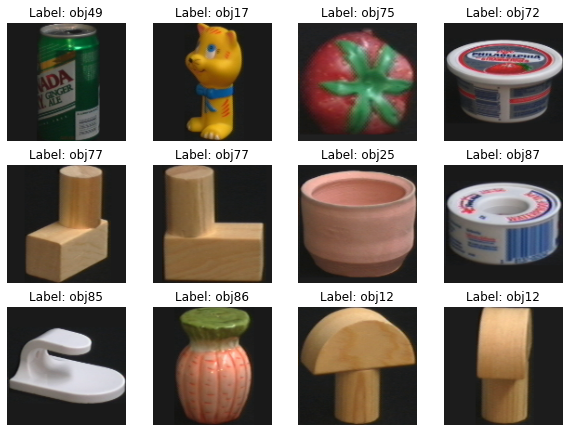

In [ ]:
# Affichage de quelques images

plt.figure(figsize=(10, 10))
for k, i in np.ndenumerate(np.random.randint(images_objets.shape[0], size=12)):
    ax = plt.subplot(4, 4, k[0] + 1)
    plt.imshow(images_objets[i], cmap='gray')
    plt.title('Label: {}'.format(labels_objets[i]))
    plt.axis("off")

# Décompte du nombre de classe

In [ ]:
print("Nous avons {} classes (Objets différents) dans notre dataset".format(len(np.unique(labels_objets))))

Nous avons 60 classes (Objets différents) dans notre dataset


# Division des données en train et test

In [ ]:
images_train, images_test, labels_train, labels_test = train_test_split(images_objets, labels_objets, test_size=0.5, random_state=42)

In [ ]:
print("Images d'entrainemment : {}".format(images_train.shape))
print("Labels d'entrainemment : {}".format(labels_train.shape))
print("Nous avons {} classes (Objets différents) dans notre train data".format(len(np.unique(labels_train))))
print()
print("Images de test : {}".format(images_test.shape))
print("Labels de test : {}".format(labels_test.shape))
print("Nous avons {} classes (Objets différents) dans notre test data".format(len(np.unique(labels_test))))

Images d'entrainemment : (1440, 128, 128, 3)
Labels d'entrainemment : (1440,)
Nous avons 60 classes (Objets différents) dans notre train data

Images de test : (1440, 128, 128, 3)
Labels de test : (1440,)
Nous avons 60 classes (Objets différents) dans notre test data


# Conversion des images d'entrainement et de test en gray

In [ ]:
images_train_gray = RGB_to_GRAY(images_train)

images_test_gray = RGB_to_GRAY(images_test)

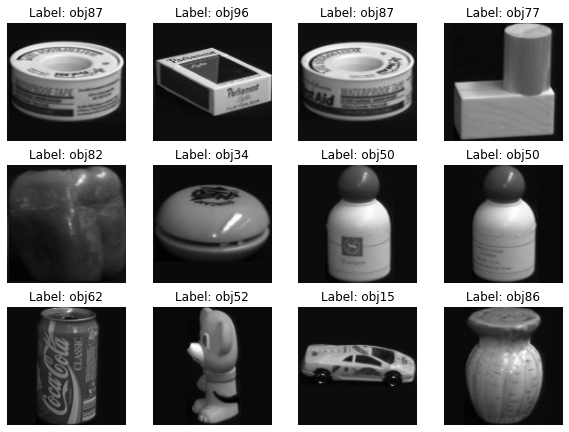

In [ ]:
# Affichage de quelques images d'entrainement en niveau de gris

plt.figure(figsize=(10, 10))
for k, i in np.ndenumerate(np.random.randint(images_train_gray.shape[0], size=12)):
    ax = plt.subplot(4, 4, k[0] + 1)
    plt.imshow(images_train_gray[i], cmap='gray')
    plt.title('Label: {}'.format(labels_train[i]))
    plt.axis("off")

# Calsuls des descripteurs locaux pour les images d'entrainement et de test

In [ ]:
descripteurs_train, images_kp_train, kp_train = description(images_train, images_train_gray)

descripteurs_test, images_kp_test, kp_test = description(images_test, images_test_gray)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


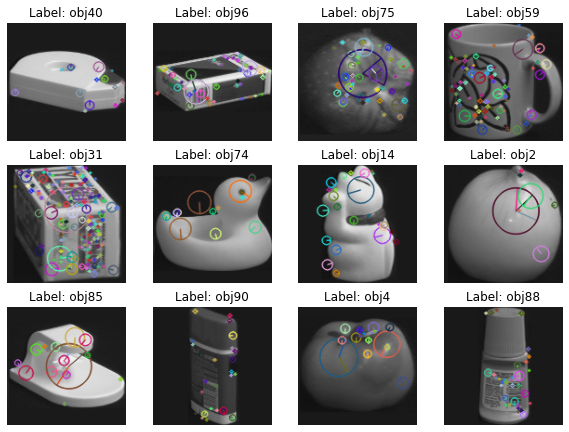

In [ ]:
# Affichage de quelques images d'entrainement avec leur description

plt.figure(figsize=(10, 10))
for k, i in np.ndenumerate(np.random.randint(images_kp_train.shape[0], size=12)):
    ax = plt.subplot(4, 4, k[0] + 1)
    plt.imshow(images_kp_train[i])
    plt.title('Label: {}'.format(labels_train[i]))
    plt.axis("off")

In [ ]:
# Affichage d'un descripteur
descripteurs_train[0][0]

array([  0.,   0.,   0.,   0.,   6.,   7.,   0.,   0.,   9.,   2.,   1.,
         0.,   2.,   2.,   0.,  13.,  80.,   2.,   0.,   0.,   0.,   0.,
         0., 149.,  52.,   0.,   0.,   0.,   0.,   0.,  41., 149.,   0.,
         0.,   0.,   0.,   4.,   8.,   0.,   0.,  75.,   1.,   0.,   0.,
         4.,   9.,   1.,  27., 149.,  16.,   0.,   0.,   0.,   0.,   1.,
       149.,  63.,  15.,   9.,   5.,   0.,   0.,  23., 149.,   0.,   0.,
         0.,   0.,   1.,   2.,   0.,   0.,  78.,  17.,   0.,   0.,   1.,
         5.,   1.,   4., 149., 149.,  27.,   0.,   0.,   0.,   0.,   9.,
        44., 120., 149.,  24.,   0.,   0.,   0.,   4.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   7.,  12.,   0.,   0.,   0.,   1.,
         0.,   0.,  17., 131.,  48.,   0.,   0.,   0.,   0.,   0.,   0.,
        67., 112.,   3.,   0.,   0.,   0.,   0.], dtype=float32)

In [ ]:
# Sauvegarde des descripteurs
np.save('descripteurs.npy', descripteurs_train)
np.save('labels.npy', labels_train)
np.save('images.npy', images_train)

kp_train_old = kp_train.copy()
for i1, kp_t in enumerate(kp_train_old):
    if type(kp_t) is cv.KeyPoint:
        kp_train_old[i1] = (kp_t.pt, kp_t.size, kp_t.angle, kp_t.response, kp_t.octave, kp_t.class_id)
    else:
        for i2, kp_ in enumerate(kp_t):
            if type(kp_) is cv.KeyPoint:
                kp_train_old[i1][i2] = (kp_.pt, kp_.size, kp_.angle, kp_.response, kp_.octave, kp_.class_id)
            else:
                for i3, kp in enumerate(kp_):
                    if type(kp) is cv.KeyPoint:
                        kp_train_old[i1][i2][i3] = (kp.pt, kp.size, kp.angle, kp.response, kp.octave, kp.class_id)
np.save('k_points.npy', kp_train_old)

In [ ]:
# Lecture du tableau sauvedardé
old_descripteurs = np.load('descripteurs.npy', allow_pickle=True)
old_labels = np.load('labels.npy', allow_pickle=True)
old_images = np.load('images.npy', allow_pickle=True)

old_k_points = np.load('k_points.npy', allow_pickle=True)
for i1, kp_t in enumerate(old_k_points):
    if type(kp_t) is tuple:
        old_k_points[i1] = cv.KeyPoint(x=kp_t[0][0], y=kp_t[0][1], _size=kp_t[1], _angle=kp_t[2], _response=kp_t[3], _octave=kp_t[4], _class_id=kp_t[5]) 
    else:
        for i2, kp_ in enumerate(kp_t):
            if type(kp_) is tuple:
                old_k_points[i1][i2] = cv.KeyPoint(x=kp_[0][0], y=kp_[0][1], _size=kp_[1], _angle=kp_[2], _response=kp_[3], _octave=kp_[4], _class_id=kp_[5]) 
            else:
                for i3, kp in enumerate(kp_):
                    if type(kp) is tuple:
                        old_k_points[i1][i2][i3] = cv.KeyPoint(x=kp[0][0], y=kp[0][1], _size=kp[1], _angle=kp[2], _response=kp[3], _octave=kp[4], _class_id=kp[5])


# Mise en correspondance (matching) de points d’intérêts

In [ ]:
c = score_match(descripteurs_train, descripteurs_test[29], 0.6)

# Recherche des index des K plus grande valeur de score

In [ ]:
pred = get_k_max_index(c[0], c[1], K, labels_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
pred

array([['obj59', 0.68,
        list([<DMatch 0x7f69b976eb50>, <DMatch 0x7f69b976eb10>, <DMatch 0x7f69b976eaf0>, <DMatch 0x7f69b976ead0>, <DMatch 0x7f69b976eab0>, <DMatch 0x7f69b976eb30>, <DMatch 0x7f69b976ea90>, <DMatch 0x7f69b976ea70>, <DMatch 0x7f69b976ea50>, <DMatch 0x7f69b976ea30>, <DMatch 0x7f69b976ea10>, <DMatch 0x7f69b976e9f0>, <DMatch 0x7f69b976e9d0>, <DMatch 0x7f69b976e9b0>, <DMatch 0x7f69b976e990>, <DMatch 0x7f69b976e970>, <DMatch 0x7f69b976e950>, <DMatch 0x7f69b976e930>, <DMatch 0x7f69b976e910>, <DMatch 0x7f69b976e8f0>, <DMatch 0x7f69b976e8d0>, <DMatch 0x7f69b976e8b0>, <DMatch 0x7f69b976e890>, <DMatch 0x7f69b976e870>, <DMatch 0x7f69b976e850>, <DMatch 0x7f69b976e830>, <DMatch 0x7f69b976e810>, <DMatch 0x7f69b976e7f0>, <DMatch 0x7f69b976e7d0>, <DMatch 0x7f69b976e7b0>, <DMatch 0x7f69b976e790>, <DMatch 0x7f69b976e770>, <DMatch 0x7f69b976e750>, <DMatch 0x7f69b976e710>, <DMatch 0x7f69b976e730>, <DMatch 0x7f69b976e6f0>, <DMatch 0x7f69b976e6d0>, <DMatch 0x7f69b976e6b0>, <DMatch 0x7f6

In [ ]:
labels_test[29]

'obj59'

# Visualisation des prédictions

In [ ]:
img_pred = 32
result = predict_desc(descripteurs_test[img_pred], descripteurs_train, labels_train, 0.6, 5)
result

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


array(['obj17', 0.28,
       list([<DMatch 0x7f69b8a36770>, <DMatch 0x7f69b8a36790>, <DMatch 0x7f69b8a366b0>, <DMatch 0x7f69b8a367d0>, <DMatch 0x7f69b8a367b0>, <DMatch 0x7f69b8a36750>, <DMatch 0x7f69b8a367f0>, <DMatch 0x7f69b8a36810>, <DMatch 0x7f69b8a36850>, <DMatch 0x7f69b8a36830>, <DMatch 0x7f69b8a36870>, <DMatch 0x7f69b8a36890>, <DMatch 0x7f69b8a368d0>]),
       925], dtype=object)

In [ ]:
out = cv.drawMatches(images_train[result[3]], kp_train[result[3]], images_test[img_pred],
                         kp_test[img_pred], result[2], None)

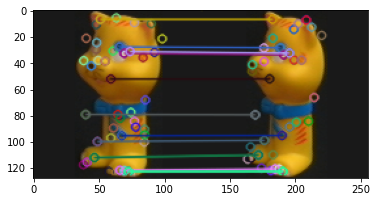

In [ ]:
plt.imshow(out)

# Evaluation

In [ ]:
label_pred = evaluate(0.6, 5)

Prediction:   0%|           [ time left: ? ]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Prediction: 100%|██████████ [ time left: 00:00 ]


In [ ]:
# Calcul du score
sum(label_pred == labels_test) / labels_test.shape[0]

0.86875

In [ ]:
saveP = np.array(label_pred)
np.save('/content/drive/MyDrive/label_predit.npy', saveP)
saveT = labels_test
np.save('/content/drive/MyDrive/label_test.npy', saveT)

In [ ]:
labels_test = np.load('/content/drive/MyDrive/label_test.npy', allow_pickle=True)
label_pred = np.load('/content/drive/MyDrive/label_predit.npy', allow_pickle=True)

In [ ]:
np.unique(labels_test)

array(['obj1', 'obj10', 'obj100', 'obj11', 'obj12', 'obj14', 'obj15',
       'obj16', 'obj17', 'obj2', 'obj20', 'obj21', 'obj23', 'obj24',
       'obj25', 'obj27', 'obj28', 'obj3', 'obj30', 'obj31', 'obj32',
       'obj33', 'obj34', 'obj36', 'obj37', 'obj4', 'obj40', 'obj41',
       'obj42', 'obj46', 'obj48', 'obj49', 'obj50', 'obj51', 'obj52',
       'obj53', 'obj57', 'obj59', 'obj6', 'obj60', 'obj62', 'obj63',
       'obj64', 'obj68', 'obj69', 'obj70', 'obj72', 'obj73', 'obj74',
       'obj75', 'obj77', 'obj8', 'obj80', 'obj82', 'obj85', 'obj86',
       'obj87', 'obj88', 'obj90', 'obj96'], dtype='<U6')

# Matrice de confusion

In [ ]:
#data
y_test = labels_test
predic = np.array(label_pred)

columns = [x for x in np.unique(labels_test)]
annot = True;
cmap = 'Oranges';
fmt = '.2f'
lw = 0.5
cbar = False
show_null_values = 2
pred_val_axis = 'y'
#size::
fz = 40;
figsize = [40,40];
plot_confusion_matrix_from_data(y_test, predic, columns,
                                annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)

NameError: ignored

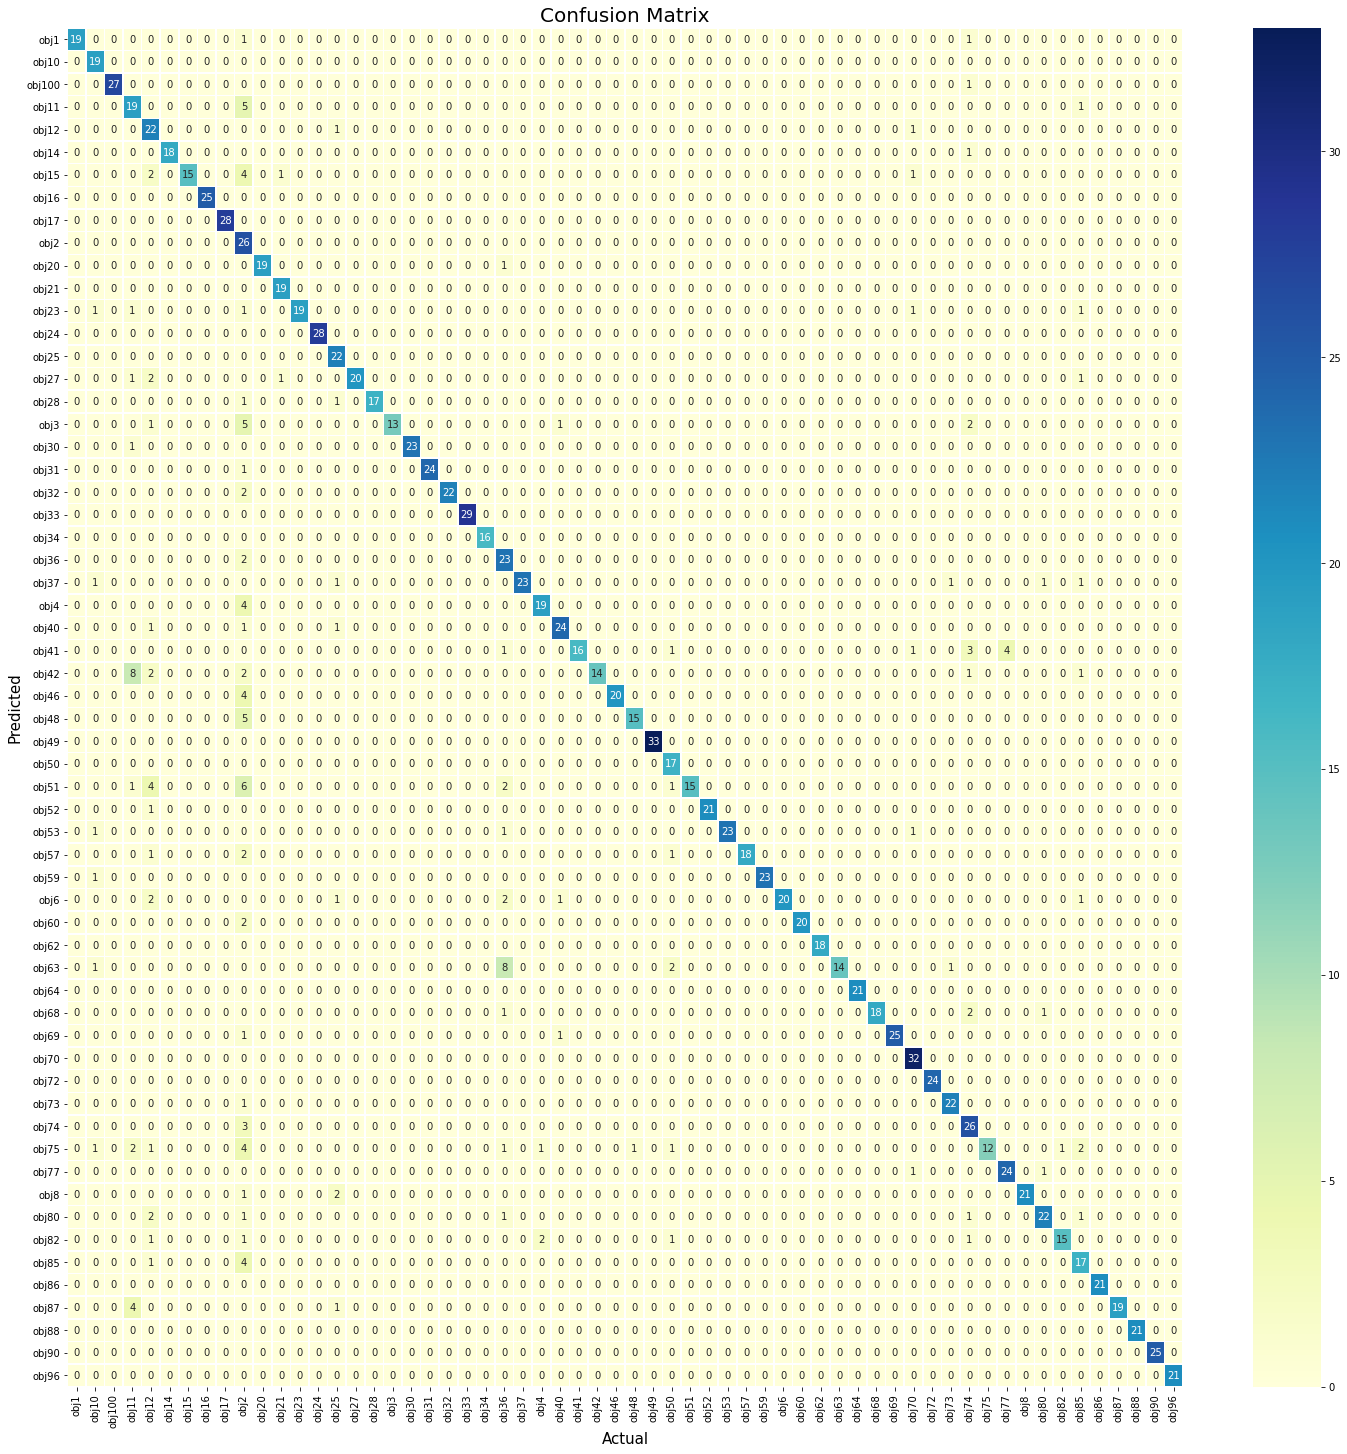

In [ ]:
confm = confusion_matrix(labels_test, np.array(label_pred), np.unique(labels_test))

df_cm = pd.DataFrame(confm, index = [i for i in np.unique(labels_test)],
              columns = [i for i in np.unique(labels_test)])

plt.figure(figsize = (25,25))
plt.title('Confusion Matrix', fontsize = 20)
sn.heatmap(df_cm, annot=True, cmap="YlGnBu", linewidths=.5)
plt.xlabel('Actual', fontsize = 15) 
plt.ylabel('Predicted', fontsize = 15) 
plt.show()

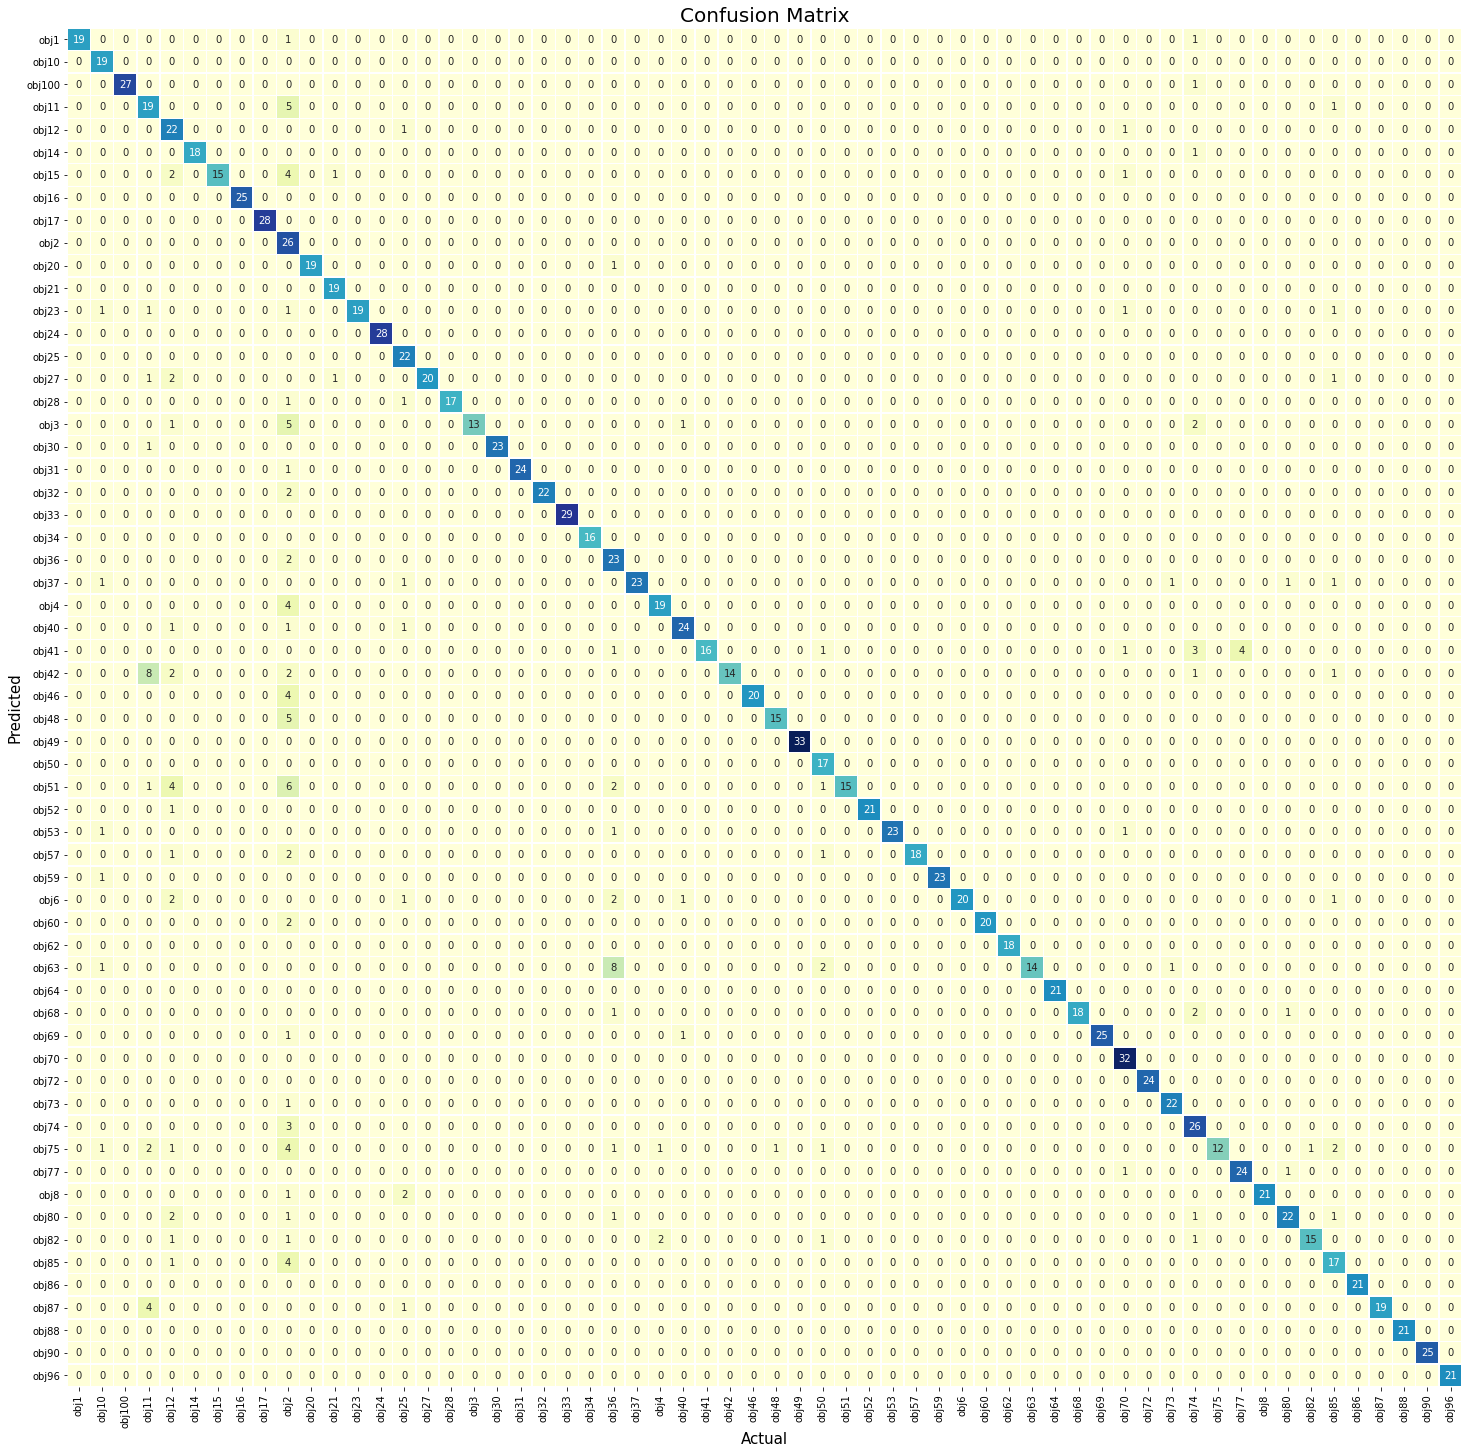

In [ ]:
confm = confusion_matrix(labels_test, np.array(label_pred), np.unique(labels_test))

df_cm = pd.DataFrame(confm, index = [i for i in np.unique(labels_test)],
              columns = [i for i in np.unique(labels_test)])

plt.figure(figsize = (25,25))
plt.title('Confusion Matrix', fontsize = 20)
sn.heatmap(df_cm, annot=True, cmap="YlGnBu", linewidths=.5, cbar=False)
plt.xlabel('Actual', fontsize = 15) 
plt.ylabel('Predicted', fontsize = 15) 
plt.show()

In [ ]:
print(classification_report(labels_test, label_pred))

              precision    recall  f1-score   support

        obj1       1.00      0.90      0.95        21
       obj10       0.76      1.00      0.86        19
      obj100       1.00      0.96      0.98        28
       obj11       0.51      0.76      0.61        25
       obj12       0.51      0.92      0.66        24
       obj14       1.00      0.95      0.97        19
       obj15       1.00      0.65      0.79        23
       obj16       1.00      1.00      1.00        25
       obj17       1.00      1.00      1.00        28
        obj2       0.29      1.00      0.45        26
       obj20       1.00      0.95      0.97        20
       obj21       0.90      1.00      0.95        19
       obj23       1.00      0.79      0.88        24
       obj24       1.00      1.00      1.00        28
       obj25       0.73      1.00      0.85        22
       obj27       1.00      0.80      0.89        25
       obj28       1.00      0.89      0.94        19
        obj3       1.00    